### Query Decomposition

The idea here is to make smaller sub-problems from bigger problems and then answer each in isolation

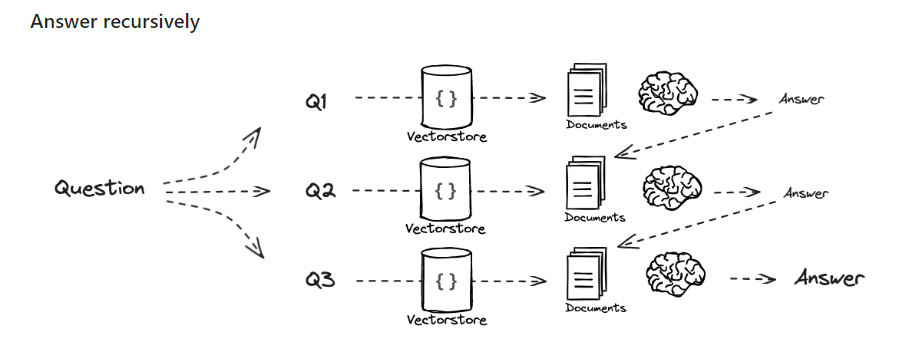

In [ ]:
# question = "What color is a watermelon?"
question = "What are volumes in Kubernetes"

In [2]:

from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash-latest", temperature=0.7, )

d:\VS Code\python\dsa_projects\RAG\notes_rag\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Create a vector database using chromaDB with document chunks

Reference - chroma_rag_hface_csv.ipynb

In [3]:
from langchain_chroma import Chroma
from langchain_community.embeddings.sentence_transformer import SentenceTransformerEmbeddings


persist_dir = "chromadb"
embedding_function = SentenceTransformerEmbeddings(model_name="all-MiniLM-L6-v2")

newdb = Chroma(persist_directory=persist_dir, embedding_function=embedding_function)
retriever = newdb.as_retriever()

d:\VS Code\python\dsa_projects\RAG\notes_rag\venv\Lib\site-packages\langchain_core\_api\deprecation.py:139: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 0.3.0. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFaceEmbeddings`.
  warn_deprecated(


### Generate sub-questions from initial question

In [4]:
from langchain_core.output_parsers import StrOutputParser
from langchain.prompts import ChatPromptTemplate

# Decomposition
template = """You are a helpful assistant that generates multiple sub-questions related to an input question. \n
The goal is to break down the input into a set of sub-problems / sub-questions that can be answers in isolation. Make sure to generate only sub-questions and no extra information \n
Generate multiple search queries related to: {question} \n
Output (3 queries):"""
prompt_decomposition = ChatPromptTemplate.from_template(template)

# Chain
generate_queries_decomposition = ( prompt_decomposition | llm | StrOutputParser() | (lambda x: x.split("\n")))

# Run
question = "What are volumes in Kubernetes?"
questions = generate_queries_decomposition.invoke({"question":question})

In [5]:
questions = [ques for ques in questions if ques!='']
questions

['- What is a Kubernetes volume?',
 '- What are the different types of Kubernetes volumes?',
 '- How do I create and use a Kubernetes volume? ']

#### We create sub-questions for a question => answer them individually => use them as context for RAG prompt => get output

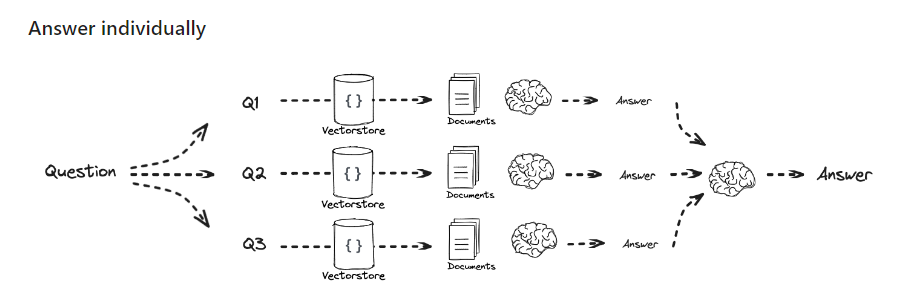

Get answer for each question individually

In [24]:
question = "What color is a watermelon?"

In [25]:
# Answer each sub-question individually 

from langchain import hub
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.output_parsers import StrOutputParser

# RAG prompt
prompt_rag = hub.pull("rlm/rag-prompt")

def retrieve_and_rag(question,prompt_rag,sub_question_generator_chain):
    """RAG on each sub-question"""
    
    # Use our decomposition / 
    sub_questions = sub_question_generator_chain.invoke({"question":question})
    
    # Initialize a list to hold RAG chain results
    rag_results = []
    
    for sub_question in sub_questions:
        
        # Retrieve documents for each sub-question
        retrieved_docs = retriever.get_relevant_documents(sub_question)
        
        # Use retrieved documents and sub-question in RAG chain
        answer = (prompt_rag | llm | StrOutputParser()).invoke({"context": retrieved_docs, 
                                                                "question": sub_question})
        rag_results.append(answer)
    
    # sub-ques and answer for each sub_question is returned, both as lists
    return rag_results,sub_questions


def format_qa_pairs(questions, answers):
    """Format Q and A pairs
    to be passed as context"""
    
    formatted_string = ""
    for i, (question, answer) in enumerate(zip(questions, answers), start=1):
        formatted_string += f"Question {i}: {question}\nAnswer {i}: {answer}\n\n"
    return formatted_string.strip()


# Wrap the retrieval and RAG process in a RunnableLambda for integration into a chain
answers, questions = retrieve_and_rag(question, prompt_rag, generate_queries_decomposition)
context = format_qa_pairs(questions, answers)

# Prompt with context and initial question to give output
template = """Here is a set of Q+A pairs:

{context}

Use these to synthesize an answer to the question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

final_rag_chain = (
    prompt
    | llm
    | StrOutputParser()
)

response = final_rag_chain.invoke({"context":context,"question":question})

In [26]:
print(response)

The provided Q&A pairs focus on Kubernetes and do not contain information about watermelons. Therefore, I cannot answer the question about the color of a watermelon. 



#### Now we need to add validation and structure so that we can return the output as input to other services as well

In [11]:
%pip install -q instructor vertexai google-generativeai

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Gemini GenerativeModel usage - https://ai.google.dev/gemini-api/docs/json-mode?lang=python

In [13]:
import os
from dotenv import load_dotenv

load_dotenv()
GOOGLE_API_KEY = os.environ["GOOGLE_API_KEY"]

In [14]:
import instructor
import google.generativeai as genai

genai.configure(api_key=GOOGLE_API_KEY)

client = instructor.from_gemini(
    client=genai.GenerativeModel(
        model_name="models/gemini-1.5-flash-latest",  # model defaults to "gemini-pro"
    ),
    mode=instructor.Mode.GEMINI_JSON,
)


In [15]:

from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash-latest", temperature=0.7, )

### Model the LLM answer storing error flag and error message in the output model

We used the patched gemini client to pass the answer as per LLMResponse

In [16]:
from instructor import llm_validator
from pydantic import BaseModel, AfterValidator, Field
from typing_extensions import Annotated
from typing import Optional, List

# if this fails then it will generate validation error
KubernetesAnswer = Annotated[
    str,
    AfterValidator(
        llm_validator("Only say about Kubernetes and it's related topics", client=client) # gemini client created above
    ),
]


class LLMResponse(BaseModel):
    question: str
    answer: str # KubernetesAnswer gives valida
    errorFlag: bool = Field(description="True if the answer is related to Kubernetes or it's related topics, False otherwise")
    errorMessage: str = Field(description="Provide the error if the user question is not related to Kubernetes or it's related topics or if you are unable to answer the question")

#### Create function to generate custom error message based on error passed to it as parameter

In [21]:
def generateError(e):
    errorMessage = client.chat.completions.create(
            messages=[
                {"role": "user", "content": f"Generate error message to user by extracting the following- {e}"}
            ]
        )
    return errorMessage

#### Validate the final response and return object based on the validation error due to `llm_validation` 

In [27]:
from pydantic import ValidationError
import json

finalResponse = None
try:
    
    finalResponse = client.chat.completions.create(
        response_model=LLMResponse,
        messages=[
            {"role": "user", "content": f"Extract to model from given question: {question} and answer: `{str(response)}`"}
        ]
    )
except ValidationError as ve:
    finalResponse = LLMResponse(
        question=question,
        answer=response,
        errorFlag=True,
        errorMessage=generateError(str(ve))
)
    

Compare the object fields for Kubernetes related and non-related questions

In [23]:
finalResponse # for question "What are volumes in Kubernetes?"

LLMResponse(question='What are volumes in Kubernetes?', answer="In Kubernetes, a **volume** is like a dedicated storage space that you can attach to a pod (a containerized application). It acts as a persistent data store, meaning the data stored within a volume will remain even if the pod is deleted or restarted. This makes volumes crucial for:\n\n* **Storing data that needs to persist beyond the lifetime of a pod:**  Imagine a web application that stores user data. You wouldn't want this data to be lost every time the pod is restarted. Volumes solve this by providing a persistent storage location.\n* **Sharing data between multiple pods:** If you have multiple pods that need access to the same data, you can attach the same volume to each pod. This allows them to all access and modify the data.\n\nKubernetes offers various types of volumes, each with its own characteristics. For example, you can use temporary volumes (`emptyDir`) that exist only for the lifetime of a pod, or persistent

In [28]:
finalResponse # for question "what color is a watermelon?"

LLMResponse(question='What color is a watermelon?', answer='The provided Q&A pairs focus on Kubernetes and do not contain information about watermelons. Therefore, I cannot answer the question about the color of a watermelon.', errorFlag=True, errorMessage='The provided Q&A pairs focus on Kubernetes and do not contain information about watermelons. Therefore, I cannot answer the question about the color of a watermelon.')

#### Do error handling using classes storing errors and messages along with responses

In [29]:
if finalResponse.errorFlag:
    print(finalResponse.errorMessage)

The provided Q&A pairs focus on Kubernetes and do not contain information about watermelons. Therefore, I cannot answer the question about the color of a watermelon.


In [36]:
finalResponse.__dict__

{'question': 'What color is a watermelon?',
 'answer': 'The provided Q&A pairs focus on Kubernetes and do not contain information about watermelons. Therefore, I cannot answer the question about the color of a watermelon.',
 'errorFlag': True,
 'errorMessage': 'The provided Q&A pairs focus on Kubernetes and do not contain information about watermelons. Therefore, I cannot answer the question about the color of a watermelon.',
 '_raw_response': response:
 GenerateContentResponse(
     done=True,
     iterator=None,
     result=protos.GenerateContentResponse({
       "candidates": [
         {
           "content": {
             "parts": [
               {
                 "text": "{\"question\": \"What color is a watermelon?\", \"answer\": \"The provided Q&A pairs focus on Kubernetes and do not contain information about watermelons. Therefore, I cannot answer the question about the color of a watermelon.\", \"errorFlag\": true, \"errorMessage\": \"The provided Q&A pairs focus on Kubern